In [3]:
path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

# Libraries

In [4]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import cv2
import timeit
import numpy as np 
import pandas as pd
from PIL import Image
from tensorflow import keras
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Conv2D,Dense,Activation,Conv2DTranspose,Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D,Concatenate

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
def num (image) :
    val = 0
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    return val

In [6]:
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m= np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [7]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[num(image)-1]+= img_to_array(pil_img)
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[num(image)-1]+= img_to_array(pil_img)

In [8]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

In [9]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


In [10]:
def convertToOneChannel(img):
    im=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    i=cv2.resize(im, (128, 128))
    return i

In [11]:
def convertToThreeChannel(img):
    b_np= np.array(img)
    g_np= np.array(img)
    r_np= np.array(img)
    final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
    return np.array(final_img)

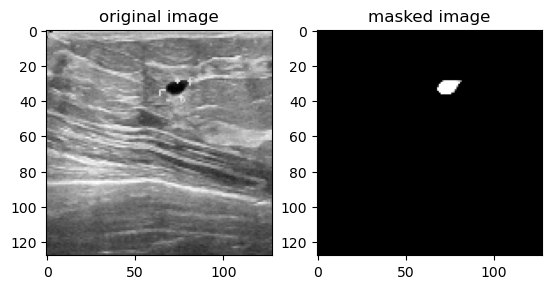

In [12]:
img=convertToThreeChannel(X[10])
mask=convertToThreeChannel(y[10])
plt.figure
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("masked image")
plt.show()

In [13]:
actual=[]
mask=[]
for i in X:
    horizontal_flip = cv2.flip(i, 1)
    vertical_horizontal_flip = cv2.flip(i, -1)
    imagerotate = cv2.rotate(i, cv2.ROTATE_180) 
    imagerotate1 = cv2.rotate(i, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate2 = cv2.rotate(i, cv2.ROTATE_90_CLOCKWISE)
    actual.append(horizontal_flip)
    actual.append(vertical_horizontal_flip)
    actual.append(imagerotate)
    actual.append(imagerotate1)
    actual.append(imagerotate2)

for j in y:
    horizontal_flip_mask = cv2.flip(j, 1)
    vertical_horizontal_flip_mask = cv2.flip(j, -1)
    imagerotate_mask1 = cv2.rotate(j, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate_mask = cv2.rotate(j, cv2.ROTATE_180)
    imagerotate_mask2 = cv2.rotate(j, cv2.ROTATE_90_CLOCKWISE)
    mask.append(horizontal_flip_mask)
    mask.append(vertical_horizontal_flip_mask)
    mask.append(imagerotate_mask)
    mask.append(imagerotate_mask1)
    mask.append(imagerotate_mask2)    

In [14]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [15]:
actual=actual/255
mask=mask/255
print(mask.max())
print(mask.min())

2.0
0.0


In [16]:
mask[mask > 1.0] = 1.0

In [17]:
print(mask.max())
print(mask.min())

1.0
0.0


In [18]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [19]:
t1=np.full(2185,1) 
t2=np.full(665,0)
t3=np.full(1050,2)  
T=np.concatenate((t1, t2, t3), axis = 0)
T=np.array(T)

In [20]:
print(T.shape)

(3900,)


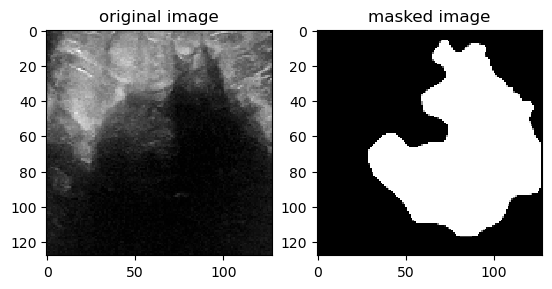

In [21]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title("masked image")
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(actual, mask, test_size = 0.15, random_state = 1)

In [23]:
actual1=[]
for i in actual:
    actual1.append(convertToThreeChannel(i) )
mask1=[]
for i in mask:
    mask1.append(convertToThreeChannel(i) )
actual1=np.array(actual1)
mask1=np.array(mask1)

In [24]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Convert grayscale images to RGB
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

In [25]:
print(X_train.shape)
print(X_test.shape)

(3315, 128, 128, 3)
(585, 128, 128, 3)


# Init model

In [26]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

""" Atrous Spatial Pyramid Pooling """
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

In [27]:
input_shape = (128, 128, 3)
model = DeepLabV3Plus(input_shape)

94765736/94765736 [==============================] - 0s 0us/step


In [28]:
model.inputs, model.outputs

([<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_1')>],
 [<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'activation_8')>])

In [29]:
from keras.metrics import MeanIoU

In [30]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00001),metrics=['acc'])

In [31]:
from keras.callbacks import ModelCheckpoint

In [32]:
checkp = ModelCheckpoint('./deeplabv3plus_model.h5', monitor = 'accuracy', save_best_only = True, verbose = 1)

# Trainning model

In [33]:
history = model.fit(X_train, y_train, epochs = 200, batch_size = 8, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/200
415/415 [==============================] - 87s 93ms/step - loss: 0.1093 - acc: 0.8599 - val_loss: 0.1892 - val_acc: 0.8073
Epoch 2/200
415/415 [==============================] - 34s 82ms/step - loss: 0.0468 - acc: 0.9448 - val_loss: 0.1500 - val_acc: 0.8468
Epoch 3/200
415/415 [==============================] - 35s 84ms/step - loss: 0.0351 - acc: 0.9569 - val_loss: 0.0585 - val_acc: 0.9315
Epoch 4/200
415/415 [==============================] - 35s 84ms/step - loss: 0.0290 - acc: 0.9636 - val_loss: 0.0322 - val_acc: 0.9594
Epoch 5/200
415/415 [==============================] - 35s 84ms/step - loss: 0.0240 - acc: 0.9689 - val_loss: 0.0235 - val_acc: 0.9700
Epoch 6/200
415/415 [==============================] - 35s 84ms/step - loss: 0.0206 - acc: 0.9730 - val_loss: 0.0234 - val_acc: 0.9704
Epoch 7/200
415/415 [==============================] - 34s 81ms/step - loss: 0.0186 - acc: 0.9752 - val_loss: 0.0224 - val_acc: 0.9709
Epoch 8/200
415/415 [==============================] - 

In [34]:
def plotOutput(history, className, epochs):
    k = ''
    if 'accuracy' in history.history :
        k = 'accuracy'    

    if 'acc' in history.history :
        k = 'acc'
    
    acc = history.history[k]
    val_acc = history.history['val_'+k]

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

# Model Metrics

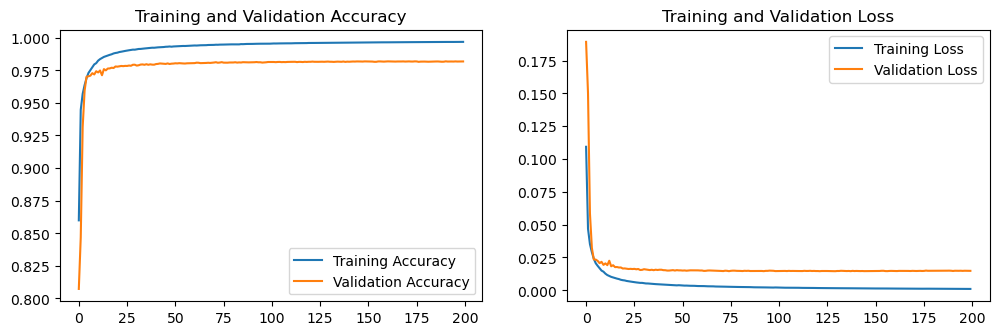

<Figure size 640x480 with 0 Axes>

In [35]:
plotOutput(history, 'Breast cancer', 200)

In [36]:
#6937s
score = model.evaluate(X_test, y_test, verbose = 1) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]*100)

19/19 [==============================] - 6s 134ms/step - loss: 0.0148 - acc: 0.9818
Test loss: 0.014780861325562
Test accuracy: 98.17817807197571


In [37]:
model.save("./deeplabv3plus_model.h5")

In [38]:
import numpy as np

def dice_coefficient(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1.)

In [39]:
def imgpredicting(img, mask):
    x=np.array([img])
    x = np.expand_dims(x, axis=-1)
    x = np.repeat(x, 3, axis=-1)  # add channel dimension and set its size to 3
    output=model.predict(x)
    output=np.array(output)
    array = np.reshape(output[0], (128, 128))
    dice = dice_coefficient(mask, array)
    print(dice)
    return array

1/1 [==============================] - 1s 993ms/step
0.9801728302068105


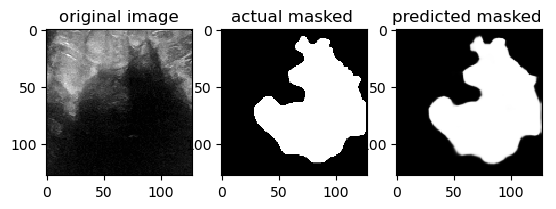

In [40]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title("actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[3000], mask[3000]),interpolation='nearest',cmap='gray')
plt.title("predicted masked ")
plt.show()

1/1 [==============================] - 0s 23ms/step
0.981923197013595


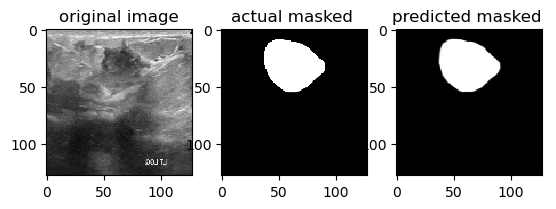

In [41]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[2000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[2000],interpolation='nearest',cmap='gray')
plt.title("actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[2000], mask[2000]),interpolation='nearest',cmap='gray')
plt.title("predicted masked ")
plt.show()

1/1 [==============================] - 0s 24ms/step
0.9301336002132125


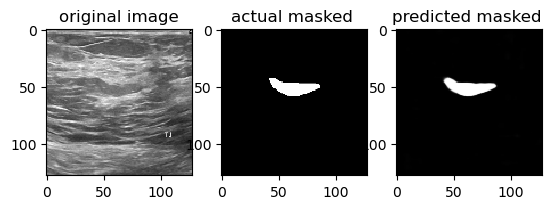

In [42]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[1000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[1000],interpolation='nearest',cmap='gray')
plt.title("actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[1000], mask[1000]),interpolation='nearest',cmap='gray')
plt.title("predicted masked ")
plt.show()

1/1 [==============================] - 0s 22ms/step
0.948058553353732


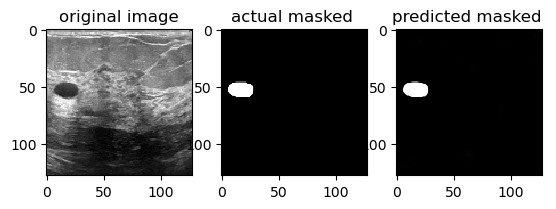

In [43]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[500],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[500],interpolation='nearest',cmap='gray')
plt.title("actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[500], mask[500]),interpolation='nearest',cmap='gray')
plt.title("predicted masked ")
plt.show()

1/1 [==============================] - 0s 25ms/step
0.9397189860695061


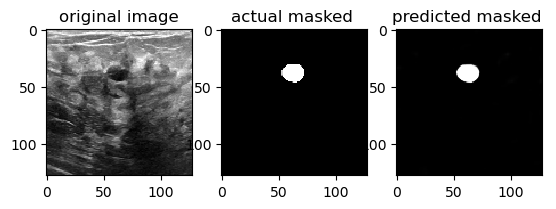

In [44]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[400],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[400],interpolation='nearest',cmap='gray')
plt.title("actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[400], mask[400]),interpolation='nearest',cmap='gray')
plt.title("predicted masked ")
plt.show()